In [1]:
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import math
import os
import cv2
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.font_manager as fm

In [2]:
from utils.plot_fig import plot_lr_all_info, plot_static_semilogy
from utils.doubly_random_matrix import get_strongly_connected_directed_row_column_stochastic_matrix
from utils.stepsize_alg import get_stepsize, get_beta1t
from utils.load_compressed_sensing import generate_compressed_sensing_data
from utils.random_quantizer import probabilistic_quantizer
from utils.uniform_quantizer import PeriodicDynamicQuantization
from utils.summary_writer import get_summary_writer
from utils.model_metrics import get_scores
from utils.data_recorder import CSTrainingRecorder
from utils.multi_robot_target_tracking import generate_multi_robot_target_tracking
from utils.load_pics import (
    load_a_picture
)
from utils.timestamp import get_strftime
from utils.make_dirs import make_dir
from utils.trust_opinion import AgentsAggregation
from utils.proj import project_onto_sphere,project_onto_l2_ball

# 0 预备

In [3]:
# 设置字体优先级：中文用宋体，英文用 Times New Roman

plt.rcParams['font.sans-serif'] = ['Times New Roman']  # ✅ 宋体+Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常

# 指定中英文字体路径
chinese_font_path = 'C:/Windows/Fonts/simsun.ttc'  # 替换为你的宋体路径
english_font_path = 'C:/Windows/Fonts/times.ttf'   # 替换为 Times New Roman 路径

chinese_font = fm.FontProperties(fname=chinese_font_path)
english_font = fm.FontProperties(fname=english_font_path)

# 1 导入数据和算法

# 1.1 导入数据

In [4]:
data_name="custom"

In [5]:
np.random.seed(666)

In [6]:
agents_num = 50
# malicious_num=int(agents_num*0.4)
malicious_num=20
legitimate_num=agents_num-malicious_num

In [7]:
dims = 328
m = 10
p = 168
sparsity_level = 88
cls_nums=1

In [8]:
# 最大迭代次数
epoch_num = 1000

In [9]:
sense_strength=1
signal_strength=1
noise_variance=0.1

In [10]:
A,y,x_true=generate_compressed_sensing_data(agents_num, dims, m, p, sparsity_level, sense_strength=sense_strength,signal_strength=signal_strength, noise_variance=noise_variance)

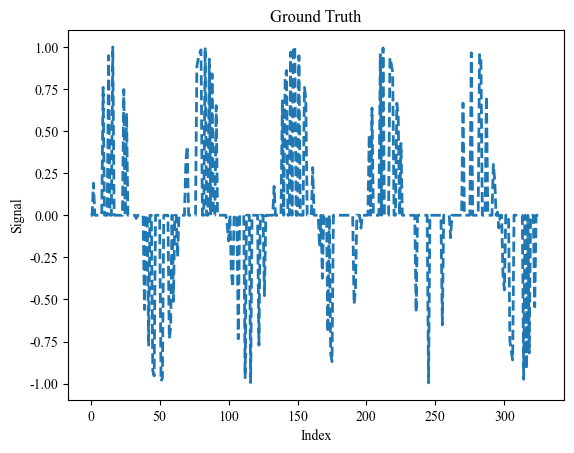

In [11]:
# 画图部分
plt.figure()
plt.plot(x_true, '--', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Signal')
plt.title('Ground Truth')
plt.show()

In [12]:
x_true.shape

(328, 1)

In [13]:
A.shape

(50, 10, 168, 328)

In [14]:
y.shape

(50, 10, 168, 1)

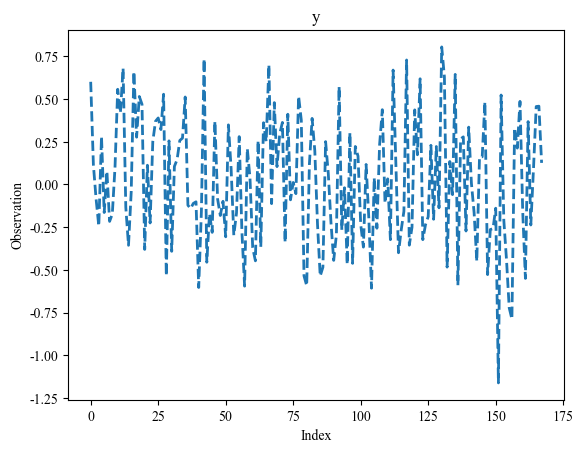

In [15]:
# 画图部分
plt.figure()
plt.plot(y[0,0], '--', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Observation')
plt.title('y')
plt.show()

### 中文输入信号图像绘制

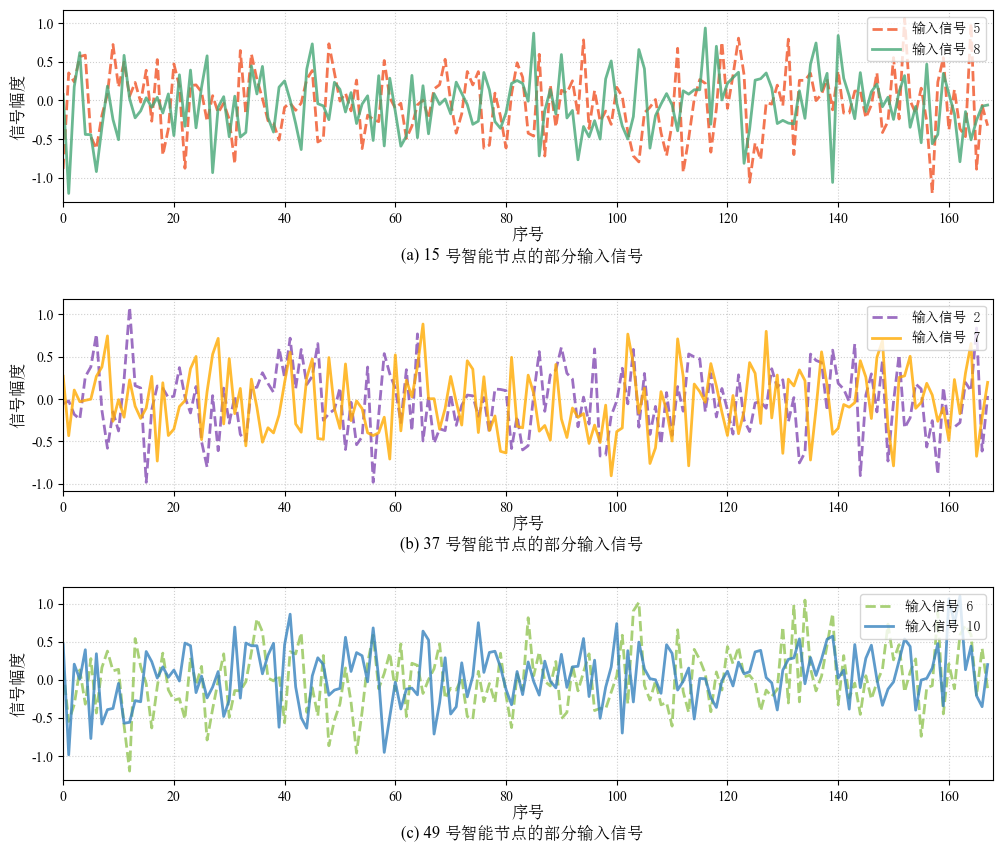

In [16]:
measure_data_len = y.shape[2]
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.5}  # 增加垂直间距为标签腾出空间
)

color_ls = ["f05326","45a776","844bb3","ffaa00","93c555","3682be"]
agent_indices = [15, 37, 49]
plot_indices = [[4,7], [1,6], [5,9]]
color_iter = iter(color_ls)

linestyle=["--","-","--","-","--","-",]
iter_linestyle=iter(linestyle)

for idx, (ax, agent_index) in enumerate(zip(axes, agent_indices)):
    for i in plot_indices[idx]:
        ax.plot(
            y[agent_index, i], next(iter_linestyle),
            linewidth=2, color='#'+next(color_iter),
            alpha=0.8, label=f'输入信号 {i+1}'
        )
    
    ax.set_xlabel('序号', fontsize=12,fontproperties=chinese_font)  # 增加labelpad给标签腾空间
    ax.set_ylabel('信号幅度', fontsize=12,fontproperties=chinese_font)
    # 将 y 轴标签向上移动，x=0.0 表示标签水平位置（通常0-1之间），y=0.6 表示标签垂直位置
    ax.xaxis.set_label_coords(0.5, -0.125)
    ax.legend(loc='upper right', prop=chinese_font)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xlim(0, int(measure_data_len*1.002))
    # ax.set_title(f'Agent {agent_index}', fontsize=12)
    ax.xaxis.set_tick_params(labelbottom=True)  # ✅ 强制显示X轴刻度
    ax.text(0.41, -0.275, f'({chr(97+idx)}) {agent_index} ', transform=ax.transAxes,
                 ha='right', va='center', fontsize=12,fontproperties=english_font)
    ax.text(0.41, -0.275, f'号智能节点的部分输入信号', transform=ax.transAxes,
                 ha='left', va='center', fontsize=12,fontproperties=chinese_font)

plt.show()

# 保存时使用bbox_inches='tight'确保包含新增标签
ext = "png"
fig.savefig(
    "figs/input-q-dadam-ps-signal-compressed.png",
    format=ext,
    bbox_inches='tight',
    dpi=300,
    pad_inches=0.1,
    facecolor='auto',
    metadata={'Creator': ''},
    quality=95 if ext == 'jpg' else None
)

### 英文输入信号图像绘制

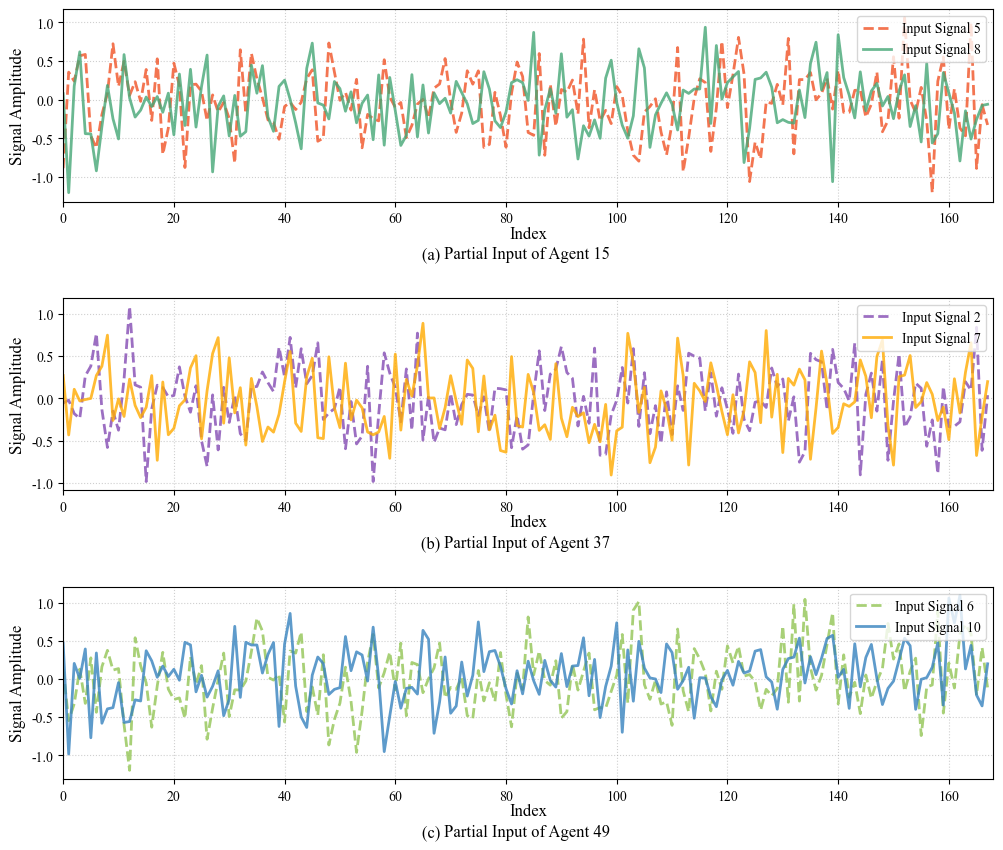

In [ ]:
measure_data_len = y.shape[2]
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.5}  # 增加垂直间距为标签腾出空间
)

color_ls = ["f05326","45a776","844bb3","ffaa00","93c555","3682be"]
agent_indices = [15, 37, 49]
plot_indices = [[4,7], [1,6], [5,9]]
color_iter = iter(color_ls)

linestyle=["--","-","--","-","--","-",]
iter_linestyle=iter(linestyle)

for idx, (ax, agent_index) in enumerate(zip(axes, agent_indices)):
    for i in plot_indices[idx]:
        ax.plot(
            y[agent_index, i], next(iter_linestyle),
            linewidth=2, color='#'+next(color_iter),
            alpha=0.8, label=f'Input Signal {i+1}'
        )
    
    ax.set_xlabel('Index', fontsize=12)  # 增加labelpad给标签腾空间
    ax.set_ylabel('Signal Amplitude', fontsize=12)
    # 将 y 轴标签向上移动，x=0.0 表示标签水平位置（通常0-1之间），y=0.6 表示标签垂直位置
    ax.xaxis.set_label_coords(0.5, -0.125)
    ax.legend(loc='upper right')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xlim(0, int(measure_data_len*1.002))
    # ax.set_title(f'Agent {agent_index}', fontsize=12)
    ax.xaxis.set_tick_params(labelbottom=True)  # ✅ 强制显示X轴刻度
    ax.text(0.41, -0.275, f'({chr(97+idx)}) ', transform=ax.transAxes,
                 ha='right', va='center', fontsize=12)
    ax.text(0.41, -0.275, f'Partial Input Signal of Agent {agent_index}', transform=ax.transAxes,
                 ha='left', va='center', fontsize=12)

plt.show()

# 保存时使用bbox_inches='tight'确保包含新增标签
ext = "pdf"
fig.savefig(
    f"figs_en/input-q-dadam-ps-signal-compressed_en.{ext}",
    format=ext,
    bbox_inches='tight',
    dpi=300,
    pad_inches=0.1,
    facecolor='auto',
    metadata={'Creator': ''},
    quality=95 if ext == 'jpg' else None
)

In [18]:
x_true.shape

(328, 1)

# 1.2 导入算法

In [18]:
alg_table={
    "q-pdq":False,
    "q-dadam-ps":True,
}

# 2 初始化

## 2.1 初始化模型参数

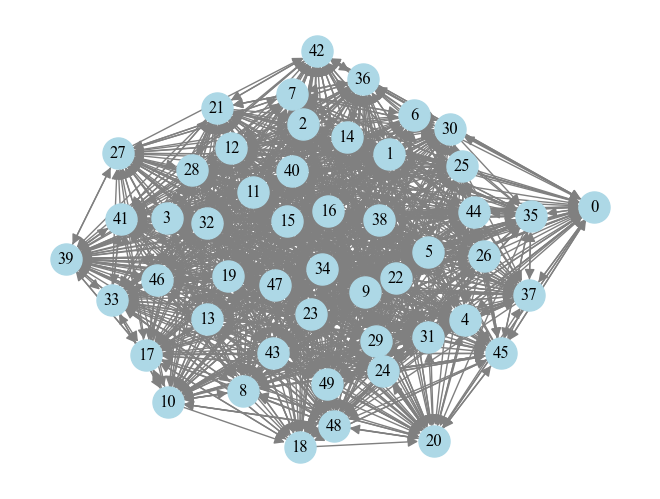

In [19]:
R,C = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num,show=True)
net = C.T

In [20]:
# w_init = np.random.normal(scale=sense_strength,size=x_true.shape)
w_init = np.zeros(x_true.shape)

In [21]:
w_init.shape

(328, 1)

In [22]:
lambda_param=0.01
# lambda_param=0

In [23]:
non_convex_alpha=1e-3
# non_convex_alpha=0
non_convex_beta=1

In [24]:
epsilon = 1e-15

## 2.2 设置损失函数

In [25]:
def loss_fn(x,i,index:list=None,A=A, y=y,rho=0.011):
    """
    计算压缩感知问题的损失函数。

    参数:
    A -- 感测矩阵列表
    y -- 测量值列表
    x -- 预测值
    i -- 节点编号
    rho -- 正则化参数

    返回:
    loss -- 损失函数值
    """
    
    loss=0
    if not index:
        num=len(A[i])
        for tmp_A,tmp_y in zip(A[i],y[i]):
            diff=tmp_A@x-tmp_y
            loss+=0.5*np.linalg.norm(diff,ord=2)**2
    else:
        num=len(index)
        for tmp_A,tmp_y in zip(A[i,index],y[i,index]):
            diff=tmp_A@x-tmp_y
            loss+=0.5*np.linalg.norm(diff,ord=2)**2
    loss=loss+rho*np.linalg.norm(x,ord=1)
    
    return loss

In [26]:
loss_fn(x_true,0)

8.995011518126548

In [27]:
# loss_fn(x_true,0,[1])

In [28]:
def grad_fn(x, i,index:list=None, A=A, y=y, rho=0.011):
    """
    计算压缩感知问题的损失函数的梯度。

    参数:
    x -- 预测值
    i -- 节点编号
    A -- 感测矩阵列表
    y -- 测量值列表
    rho -- 正则化参数

    返回:
    grad -- 损失函数梯度
    """
    data_fidelity_grad=np.zeros_like(x)
    if not index:
        num=len(A[i])
        for j in range(num):
            tmp_A,tmp_y=A[i,j],y[i,j]
            # 计算数据保真度项的梯度
            diff = tmp_A @ x - tmp_y
            data_fidelity_grad +=tmp_A.T @ diff
    else:
        num=len(index)
        for tmp_A,tmp_y in zip(A[i,index],y[i,index]):
            # 计算数据保真度项的梯度
            diff = tmp_A @ x - tmp_y
            data_fidelity_grad += tmp_A.T @ diff
    # print(num)
    data_fidelity_grad/=num
    
    # 计算正则化项的次梯度
    # regularization_grad = rho * np.sign(x)
    # grad=data_fidelity_grad+regularization_grad

    grad=data_fidelity_grad

    return grad 

In [29]:
x_true

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.90391109e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 7.59160485e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 9.47442049e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 9.99266181e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 7.46553222e-01],
       [ 0.00000000e+00],
       [ 6.06225411e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.91548812e-02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.0

In [30]:
grad_fn(x_true,0)

array([[ 0.02536107],
       [-0.02831647],
       [-0.01339887],
       [-0.02173202],
       [-0.03635719],
       [ 0.01597145],
       [-0.00043799],
       [ 0.00693329],
       [ 0.02057775],
       [-0.00621314],
       [-0.02059563],
       [-0.00299261],
       [ 0.01371273],
       [-0.01415527],
       [ 0.00624257],
       [-0.00410334],
       [ 0.02361085],
       [ 0.00505449],
       [ 0.0360287 ],
       [-0.030434  ],
       [-0.00626832],
       [-0.00667439],
       [-0.00807777],
       [ 0.004013  ],
       [ 0.02952505],
       [-0.01497663],
       [ 0.00156829],
       [ 0.01054881],
       [ 0.01938773],
       [ 0.00623665],
       [-0.01207403],
       [-0.00853194],
       [ 0.02545851],
       [-0.0279835 ],
       [ 0.0056644 ],
       [ 0.05121854],
       [-0.00887344],
       [ 0.02989893],
       [-0.00318701],
       [ 0.02293008],
       [-0.0151311 ],
       [-0.03909147],
       [-0.02493066],
       [-0.0112582 ],
       [ 0.00735645],
       [ 0

In [31]:
def relative_error_fn(x_node, x_true=x_true):
    """
    计算恢复信号与原始信号之间的相对误差。

    参数:
    x_k -- 在第 k 次迭代时所有节点恢复的信号列表
    x_true -- 原始稀疏信号
    m -- 节点数量

    返回:
    relative_error -- 相对误差值
    """
    # 计算每个节点恢复信号与原始信号之间的误差平方和
    error_sum = np.sum([np.linalg.norm(x - x_true) ** 2 for x in x_node])
    
    # 计算平均误差平方
    average_error = error_sum /x_node.shape[0]
    
    # 计算相对误差的对数（以10为底）
    relative_error = np.log10(average_error)
    
    return relative_error

In [32]:
relative_error_fn(np.expand_dims(w_init,0).repeat(agents_num,axis=0),x_true)

1.6584355354973874

In [33]:
quantizer=probabilistic_quantizer

## 2.3 初始化LRTrainingRecorder和SummaryWriter

In [34]:
training_recorder=CSTrainingRecorder()

In [35]:
pics_save_path=os.path.join(f"./logs/qdadamPS_pics_compare_compressed_sensing/{data_name}",get_strftime())
make_dir(pics_save_path)

In [36]:
writer = get_summary_writer(f"./logs/qdadamPS_compare_compressed_sensing/{data_name}")

## 2.4 绘图函数

In [63]:
def plot_pulse_signal_and_error_en(alg_table, alg_name, x_true, w_node, save_path=None):
    """
    根据输入数据绘制脉冲信号和误差图，优化脉冲信号特征显示
    
    参数：
    - alg_table: 包含算法状态的字典
    - alg_name: 字典中的关键字，如果对应值为True则执行绘图
    - x_true: 真实脉冲信号数据（用于子图1和误差计算）
    - w_node: 预测脉冲信号数据（用于计算均值信号）
    """
    if alg_table[alg_name]:
        measure_data_len = len(x_true)
        
        # 创建画布与子图系统：三个子图垂直排列，大小为14×10英寸
        fig, (ax1, ax2, ax3) = plt.subplots(
            nrows=3,
            figsize=(14, 12),
            sharex=True,
            gridspec_kw={'hspace': 0.35}
        )
        
        # ------ 子图1：真实脉冲信号 ------
        # 使用stem图显示离散脉冲特性[1,6](@ref)
        markerline, stemlines, baseline = ax1.stem(
            x_true, 
            linefmt='#3682be', 
            markerfmt='.',  # 取消标记
            basefmt='#3682be',
            label='True Signal'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 0, 'alpha', 0.8)
        
        ax1.set_xlabel('Index', fontsize=12)
        ax1.set_ylabel('Signal Amplitude', fontsize=12)
        ax1.xaxis.set_label_coords(0.5, -0.1)
        ax1.legend(loc='upper right')
        ax1.grid(True, linestyle=':', alpha=0.6)
        ax1.set_xlim(0,int(measure_data_len*1.002))
        ax1.xaxis.set_tick_params(labelbottom=True)  # ✅ 强制显示X轴刻度
        ax1.text(0.47, -0.225, f'(a) ', transform=ax1.transAxes,
                 ha='right', va='center', fontsize=12)
        ax1.text(0.47, -0.225, f'True Signal', transform=ax1.transAxes,
                 ha='left', va='center', fontsize=12)

        # ------ 子图2：原始信号的均值分析 ------
        mean_signal = np.mean(w_node, axis=0)

        # 使用stem图显示离散脉冲特性[1,6](@ref)
        markerline, stemlines, baseline = ax2.stem(
            mean_signal, 
            linefmt='#45a776', 
            markerfmt='.',  # 取消标记
            basefmt='#45a776',
            label='Predicted Signal'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 0, 'alpha', 0.8)

        ax2.set_xlabel('Index', fontsize=12)
        ax2.set_ylabel('Signal Amplitude', fontsize=12)
        ax2.xaxis.set_label_coords(0.5, -0.1)
        ax2.legend(loc='upper right')
        ax2.grid(True, linestyle=':', alpha=0.6)
        ax2.set_xlim(0,int(measure_data_len*1.002))
        ax2.xaxis.set_tick_params(labelbottom=True)  # ✅ 强制显示X轴刻度

        ax2.text(0.42, -0.225, f'(b) ', transform=ax2.transAxes,
                 ha='right', va='center', fontsize=12)
        ax2.text(0.42, -0.225, f'Average Predicted Signal', transform=ax2.transAxes,
                 ha='left', va='center', fontsize=12)
        
        # ------ 子图3：误差分析 ------
        error = mean_signal - x_true

         # 使用stem图显示离散脉冲特性[1,6](@ref)
        markerline, stemlines, baseline = ax3.stem(
            error, 
            linefmt='#f05326', 
            markerfmt='.',  # 取消标记
            basefmt='#f05326',
             label='Error'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 0, 'alpha', 0.8)

        ax3.set_xlabel('Index', fontsize=12)
        ax3.set_ylabel('Error', fontsize=12)
        ax3.xaxis.set_label_coords(0.5, -0.1)
        ax3.legend(loc='upper right')
        ax3.grid(True, linestyle=':', alpha=0.6)
        ax3.set_xlim(0,int(measure_data_len*1.002))

        ax3.text(0.32, -0.225, f'(c) ', transform=ax3.transAxes,
                 ha='right', va='center', fontsize=12)
        ax3.text(0.32, -0.225, f'Error Between True Signal and Average Predicted Signal', transform=ax3.transAxes,
                 ha='left', va='center', fontsize=12)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        if save_path:
            ext="pdf"
            fig.savefig(
                fname=save_path,
                format=ext,
                bbox_inches='tight',
                dpi=300,  # ✅ 分辨率倍增
                pad_inches=0.1,  # ✅ 边界留白
                facecolor='auto',  # ✅ 自动背景填充
                metadata={'Creator': ''},  # ✅ 清除元数据
                quality=95 if ext == 'jpg' else None  # ✅ 格式定制
            )

In [38]:
def plot_pulse_signal_and_error(alg_table, alg_name, x_true, w_node, save_path=None):
    """
    根据输入数据绘制脉冲信号和误差图，优化脉冲信号特征显示
    
    参数：
    - alg_table: 包含算法状态的字典
    - alg_name: 字典中的关键字，如果对应值为True则执行绘图
    - x_true: 真实脉冲信号数据（用于子图1和误差计算）
    - w_node: 预测脉冲信号数据（用于计算均值信号）
    """
    if alg_table[alg_name]:
        measure_data_len = len(x_true)
        
        # 创建画布与子图系统：三个子图垂直排列，大小为14×10英寸
        fig, (ax1, ax2, ax3) = plt.subplots(
            nrows=3,
            figsize=(14, 12),
            sharex=True,
            gridspec_kw={'hspace': 0.35}
        )
        
        # ------ 子图1：真实脉冲信号 ------
        # 使用stem图显示离散脉冲特性[1,6](@ref)
        markerline, stemlines, baseline = ax1.stem(
            x_true, 
            linefmt='#3682be', 
            markerfmt='.',  # 取消标记
            basefmt='#3682be',
            label='真实信号'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 0, 'alpha', 0.8)
        
        ax1.set_xlabel('序列', fontsize=12,fontproperties=chinese_font)
        ax1.set_ylabel('信号幅度', fontsize=12,fontproperties=chinese_font)
        ax1.xaxis.set_label_coords(0.5, -0.1)
        ax1.legend(loc='upper right',prop=chinese_font)
        ax1.grid(True, linestyle=':', alpha=0.6)
        ax1.set_xlim(0,int(measure_data_len*1.002))
        ax1.xaxis.set_tick_params(labelbottom=True)  # ✅ 强制显示X轴刻度
        ax1.text(0.45, -0.225, f'(a) ', transform=ax1.transAxes,
                 ha='right', va='center', fontsize=12,fontproperties=english_font)
        ax1.text(0.45, -0.225, f'原始真实信号', transform=ax1.transAxes,
                 ha='left', va='center', fontsize=12,fontproperties=chinese_font)

        # ------ 子图2：原始信号的均值分析 ------
        mean_signal = np.mean(w_node, axis=0)

        # 使用stem图显示离散脉冲特性[1,6](@ref)
        markerline, stemlines, baseline = ax2.stem(
            mean_signal, 
            linefmt='#45a776', 
            markerfmt='.',  # 取消标记
            basefmt='#45a776',
            label='预测信号'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 0, 'alpha', 0.8)

        ax2.set_xlabel('序列', fontsize=12,fontproperties=chinese_font)
        ax2.set_ylabel('信号幅度', fontsize=12,fontproperties=chinese_font)
        ax2.xaxis.set_label_coords(0.5, -0.1)
        ax2.legend(loc='upper right',prop=chinese_font)
        ax2.grid(True, linestyle=':', alpha=0.6)
        ax2.set_xlim(0,int(measure_data_len*1.002))
        ax2.xaxis.set_tick_params(labelbottom=True)  # ✅ 强制显示X轴刻度

        ax2.text(0.42, -0.225, f'(b) ', transform=ax2.transAxes,
                 ha='right', va='center', fontsize=12,fontproperties=english_font)
        ax2.text(0.42, -0.225, f'智能节点平均预测信号', transform=ax2.transAxes,
                 ha='left', va='center', fontsize=12,fontproperties=chinese_font)
        
        # ------ 子图3：误差分析 ------
        error = mean_signal - x_true

         # 使用stem图显示离散脉冲特性[1,6](@ref)
        markerline, stemlines, baseline = ax3.stem(
            error, 
            linefmt='#f05326', 
            markerfmt='.',  # 取消标记
            basefmt='#f05326',
             label='误差'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 0, 'alpha', 0.8)

        ax3.set_xlabel('序列', fontsize=12,fontproperties=chinese_font)
        ax3.set_ylabel('误差', fontsize=12,fontproperties=chinese_font)
        ax3.xaxis.set_label_coords(0.5, -0.1)
        ax3.legend(loc='upper right',prop=chinese_font)
        ax3.grid(True, linestyle=':', alpha=0.6)
        ax3.set_xlim(0,int(measure_data_len*1.002))

        ax3.text(0.32, -0.225, f'(c) ', transform=ax3.transAxes,
                 ha='right', va='center', fontsize=12,fontproperties=english_font)
        ax3.text(0.32, -0.225, f'原始真实信号与智能节点平均预测信号之间的误差', transform=ax3.transAxes,
                 ha='left', va='center', fontsize=12,fontproperties=chinese_font)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        if save_path:
            ext="png"
            fig.savefig(
                fname=save_path,
                format=ext,
                bbox_inches='tight',
                dpi=300,  # ✅ 分辨率倍增
                pad_inches=0.1,  # ✅ 边界留白
                facecolor='auto',  # ✅ 自动背景填充
                metadata={'Creator': ''},  # ✅ 清除元数据
                quality=95 if ext == 'jpg' else None  # ✅ 格式定制
            )

# 3 Quantized Push-Sum模型训练

## 3.1 设置优化器初始参数

In [39]:

# 初始步长

step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值


In [40]:
beta1t_lambda=0.9

In [41]:
kt_pow=1.5

In [42]:
total_iter=0

## 3.2 初始化优化器

In [43]:
w_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
quanz_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))

x_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# x_hat_node 初始化为0
x_hat_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_hat_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# y_node 初始化为1
y_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
y_prev_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
z_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))


In [44]:
for ii in range(agents_num):
    w_node[ii] = w_init.copy()
    quanz_node[ii]=quantizer(w_init,1)

    x_node[ii]=w_init.copy()
    x_prev_node[ii]=w_init.copy()

    z_node[ii]=w_init.copy()

## 3.3 模型训练

In [45]:
# 算法名称
alg_name="q-pdq"
if alg_table[alg_name]:
    alg_label = f"method_{alg_name}_step_{step_init:.2f}"
    # 初始化 训练过程记录
    training_recorder.init_alg_model(alg_label)
    # 记录初始状态
    training_recorder.auto_cal_and_append(alg_label,z_node,loss_fn,x_true,relative_error_fn)

    # 记录初始状态
    pbar=tqdm(total=epoch_num)
    for i in trange(epoch_num):
        pbar.update()
        total_iter = total_iter + 1
        kt=math.ceil((i+1)**kt_pow)
        
        step=get_stepsize(step_init,total_iter,method="decay-sq")

        x_prev_node=x_node.copy()
        x_hat_prev_node=x_hat_node.copy()
        y_prev_node=y_node.copy()

        for ii in range(agents_num):
            
            # 对权重进行量化
            quanz_node[ii]=quantizer(x_prev_node[ii]-x_hat_prev_node[ii],kt,use_quantize=True)
            x_hat_node[ii]=x_hat_prev_node[ii]+quanz_node[ii]

            w_consen_node = x_prev_node[ii]-x_hat_node[ii]
            for jj in range(agents_num):
                w_consen_node = w_consen_node + net[ii, jj] * x_hat_node[jj]
            w_node[ii] = w_consen_node

            y_consen_node=np.zeros(w_init.shape)
            for jj in range(agents_num):
                y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[ii]
            y_node[ii]=y_consen_node

            z_node[ii]=w_node[ii]/y_node[ii]
            
            # 梯度下降函数更新W权重
            grad = grad_fn(z_node[ii],ii)
            # grad = project_onto_l2_ball(grad,epoch_num+1-total_iter)
            x_node[ii]=w_node[ii]-step*grad
                
        # 记录训练过程各参数
        training_recorder.auto_cal_and_append(alg_label,z_node,loss_fn,x_true,relative_error_fn)

        pbar.set_postfix(relative_error=training_recorder.get_data_by_measure_and_alg_label('relative_error',alg_label)[i],gen=i+1)	

    pbar.close()

## 3.4 展示结果

In [46]:
if alg_table[alg_name]:
    print(loss_fn(z_node[0],0))

In [47]:
if alg_table[alg_name]:
   print(z_node[0])

# 4 Q-DADAM Push Sum 算法训练

## 4.1 设置参数

In [48]:
# 初始步长

step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值

In [49]:
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0=1e-3
beta1t_lambda=0.9

## 4.2 设置优化器初始参数

In [50]:
w_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# x_hat_node 初始化为0
quant_x_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
quant_x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_prev_node = G0**2 * np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))


x_hat_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_hat_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# y_node 初始化为1
y_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
y_prev_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))

z_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))


In [51]:
for ii in range(agents_num):
    w_node[ii] = w_init.copy()
    quant_x_node[ii]=quantizer(w_init,1)

    x_node[ii]=w_init.copy()
    x_prev_node[ii]=w_init.copy()

    z_node[ii]=w_init.copy()

In [52]:
total_iter = 0

In [53]:
kt_pow=1.5

## 4.3 模型训练

In [54]:
# 算法名称
alg_name="q-dadam-ps"

In [55]:
if alg_table[alg_name]:

    alg_label = f"method_{alg_name}_step_{step_init:.2f}"

    # 初始化 训练过程记录
    training_recorder.init_alg_model(alg_label)
    # 记录初始状态
    training_recorder.auto_cal_and_append(alg_label,w_node,loss_fn,x_true,relative_error_fn)

    pbar=tqdm(total=epoch_num)
    for i in trange(epoch_num):
        pbar.update()
        total_iter = total_iter + 1
        w_node_prev = w_node.copy()
        kt=math.ceil((i+1)**kt_pow)
        beta1t=get_beta1t(beta1,total_iter,lambda_val=beta1t_lambda)
        step=get_stepsize(step_init,total_iter,method="decay-sq")

        for ii in range(agents_num):

            # 对权重进行量化
            w_consen_node = np.zeros(w_init.shape)
            for jj in range(agents_num):
                w_consen_node = w_consen_node + net[ii,jj] * quantizer(x_prev_node[jj],kt=kt,use_quantize=True)
            w_node[ii] = w_consen_node

            y_consen_node=np.zeros(w_init.shape)
            for jj in range(agents_num):
                y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[jj]
            y_node[ii]=y_consen_node
            y_prev_node[ii]=y_node[ii].copy()

            z_node[ii]=w_node[ii]/y_node[ii]
            
            # 梯度下降函数更新W权重
            grad = grad_fn(z_node[ii],ii)
            # 加入DADAM
            m_node[ii] = (
                beta1t * m_node[ii] + (1 - beta1t) * grad
            )  # update biased first moment estimate
            v_node[ii] = beta2 * v_node[ii] + (1 - beta2) * np.power(
                grad, 2
            )  # update biased second raw moment estimate

            m_hat_node[ii] = m_node[ii] / (
                1 - beta1t**total_iter
            )  # compute bias-corrected fist moment estimate
            v_hat_node[ii] = v_node[ii] / (
                1 - beta2**total_iter
            )  # compute bias-corrected second raw moment estimate

            v_bar_node[ii] = beta3 * v_bar_prev_node[ii] + (1 - beta3) * np.where(
            v_hat_node[ii]>v_bar_prev_node[ii], v_hat_node[ii],v_bar_prev_node[ii])  # normalize second raw moment

            v_bar_prev_node[ii]=v_bar_node[ii].copy()       

            x_node[ii] = w_node[ii] - step * m_hat_node[ii] / (
            np.sqrt(v_bar_node[ii] )+ epsilon
            )
            x_prev_node[ii]=x_node[ii].copy()
            
        # 计算损失函数
        # 记录初始状态
        training_recorder.auto_cal_and_append(alg_label,w_node,loss_fn,x_true,relative_error_fn)
        pbar.set_postfix(relative_error=training_recorder.get_data_by_measure_and_alg_label('relative_error',alg_label)[i+1],loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i+1],gen=i+1)
    pbar.close()

100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s, gen=1000, loss=8.96, relative_error=-1.64]


## 4.4 展示结果

### 中文图像绘制

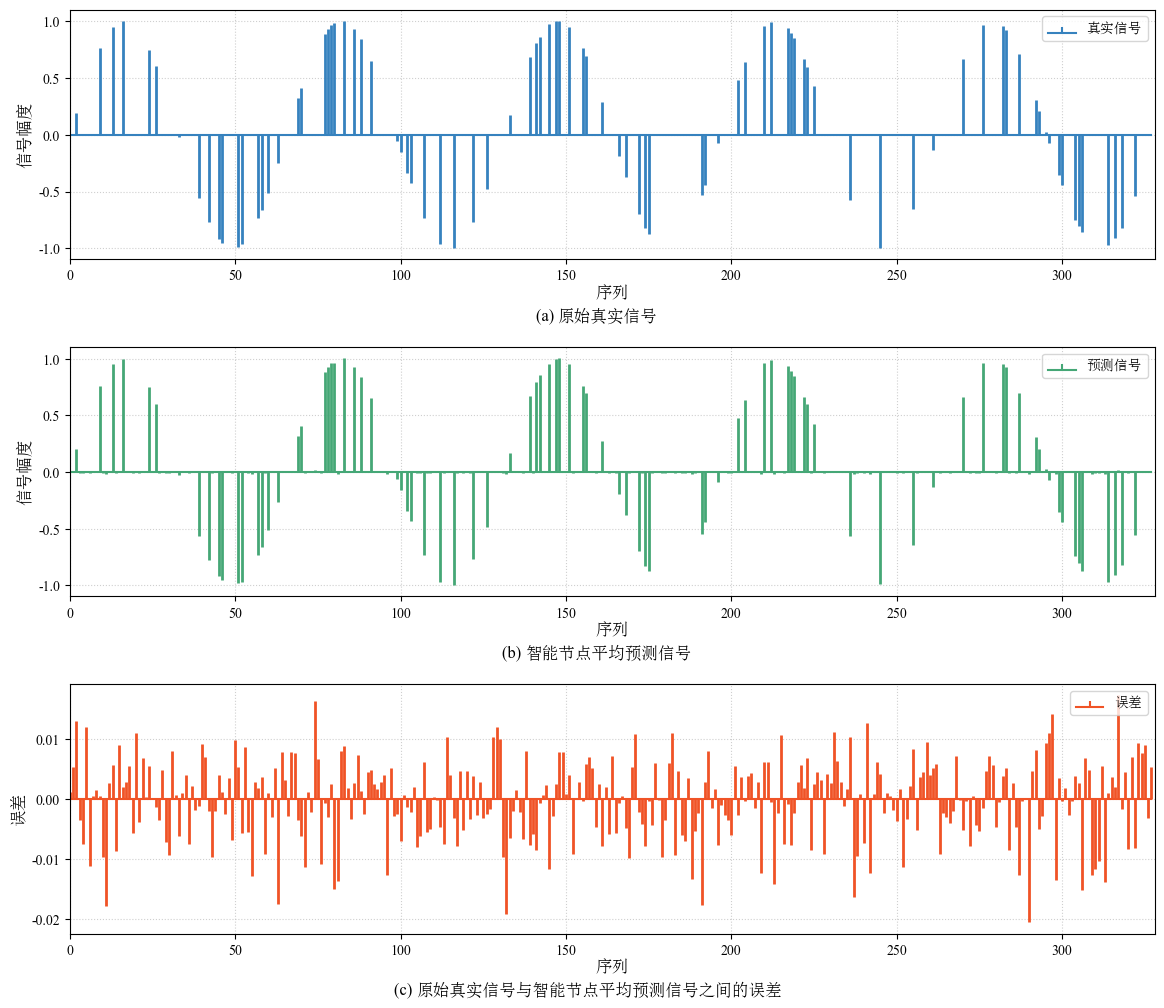

In [57]:
plot_pulse_signal_and_error(alg_table, alg_name, x_true, w_node,"figs/stem_q-dadam--ps-signal-compressed.png")

### 英文图像绘制

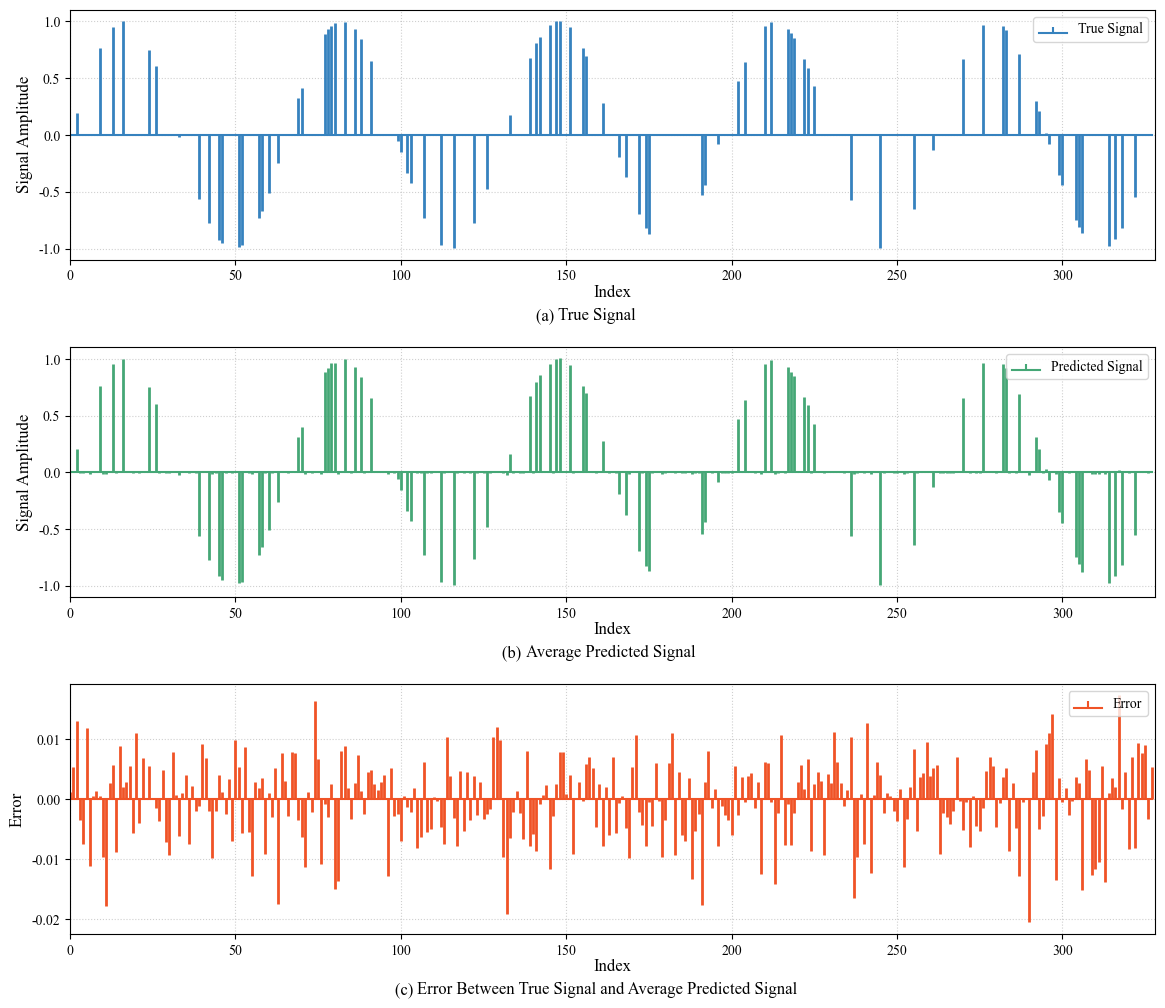

In [60]:
plot_pulse_signal_and_error_en(alg_table, alg_name, x_true, w_node,"figs_en/stem_q-dadam--ps-signal-compressed_en.pdf")

# 数据处理

In [ ]:
# 导出所有数据，并绘制到tensorboard
recorded_data=training_recorder.get_all_data_for_writer_scalars()
for measure,recorder_ls in recorded_data.items():
    epoch=0
    for d in recorder_ls:
        writer.add_scalars(measure,d,epoch)
        epoch=epoch+1